In [334]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers import Dense, Activation, Flatten, Dropout

In [335]:
import pathlib
data_dir = pathlib.Path('fire_dataset')

In [336]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

999


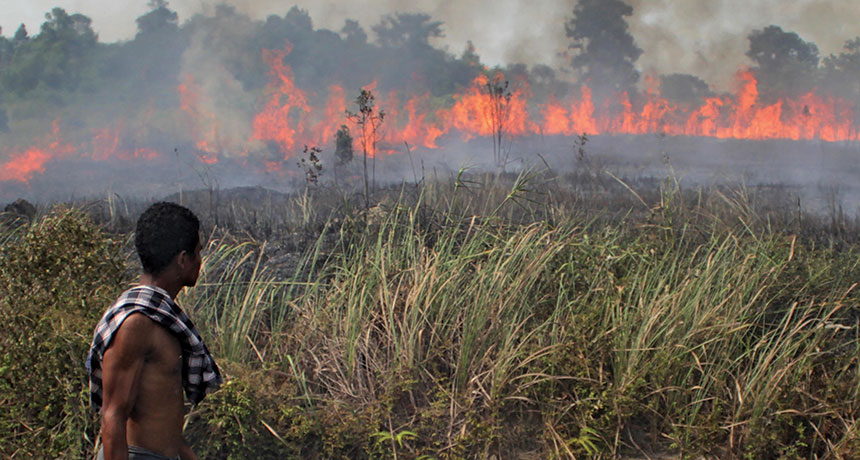

In [337]:
fire = list(data_dir.glob('fire_images/*'))
PIL.Image.open(str(fire[0]))

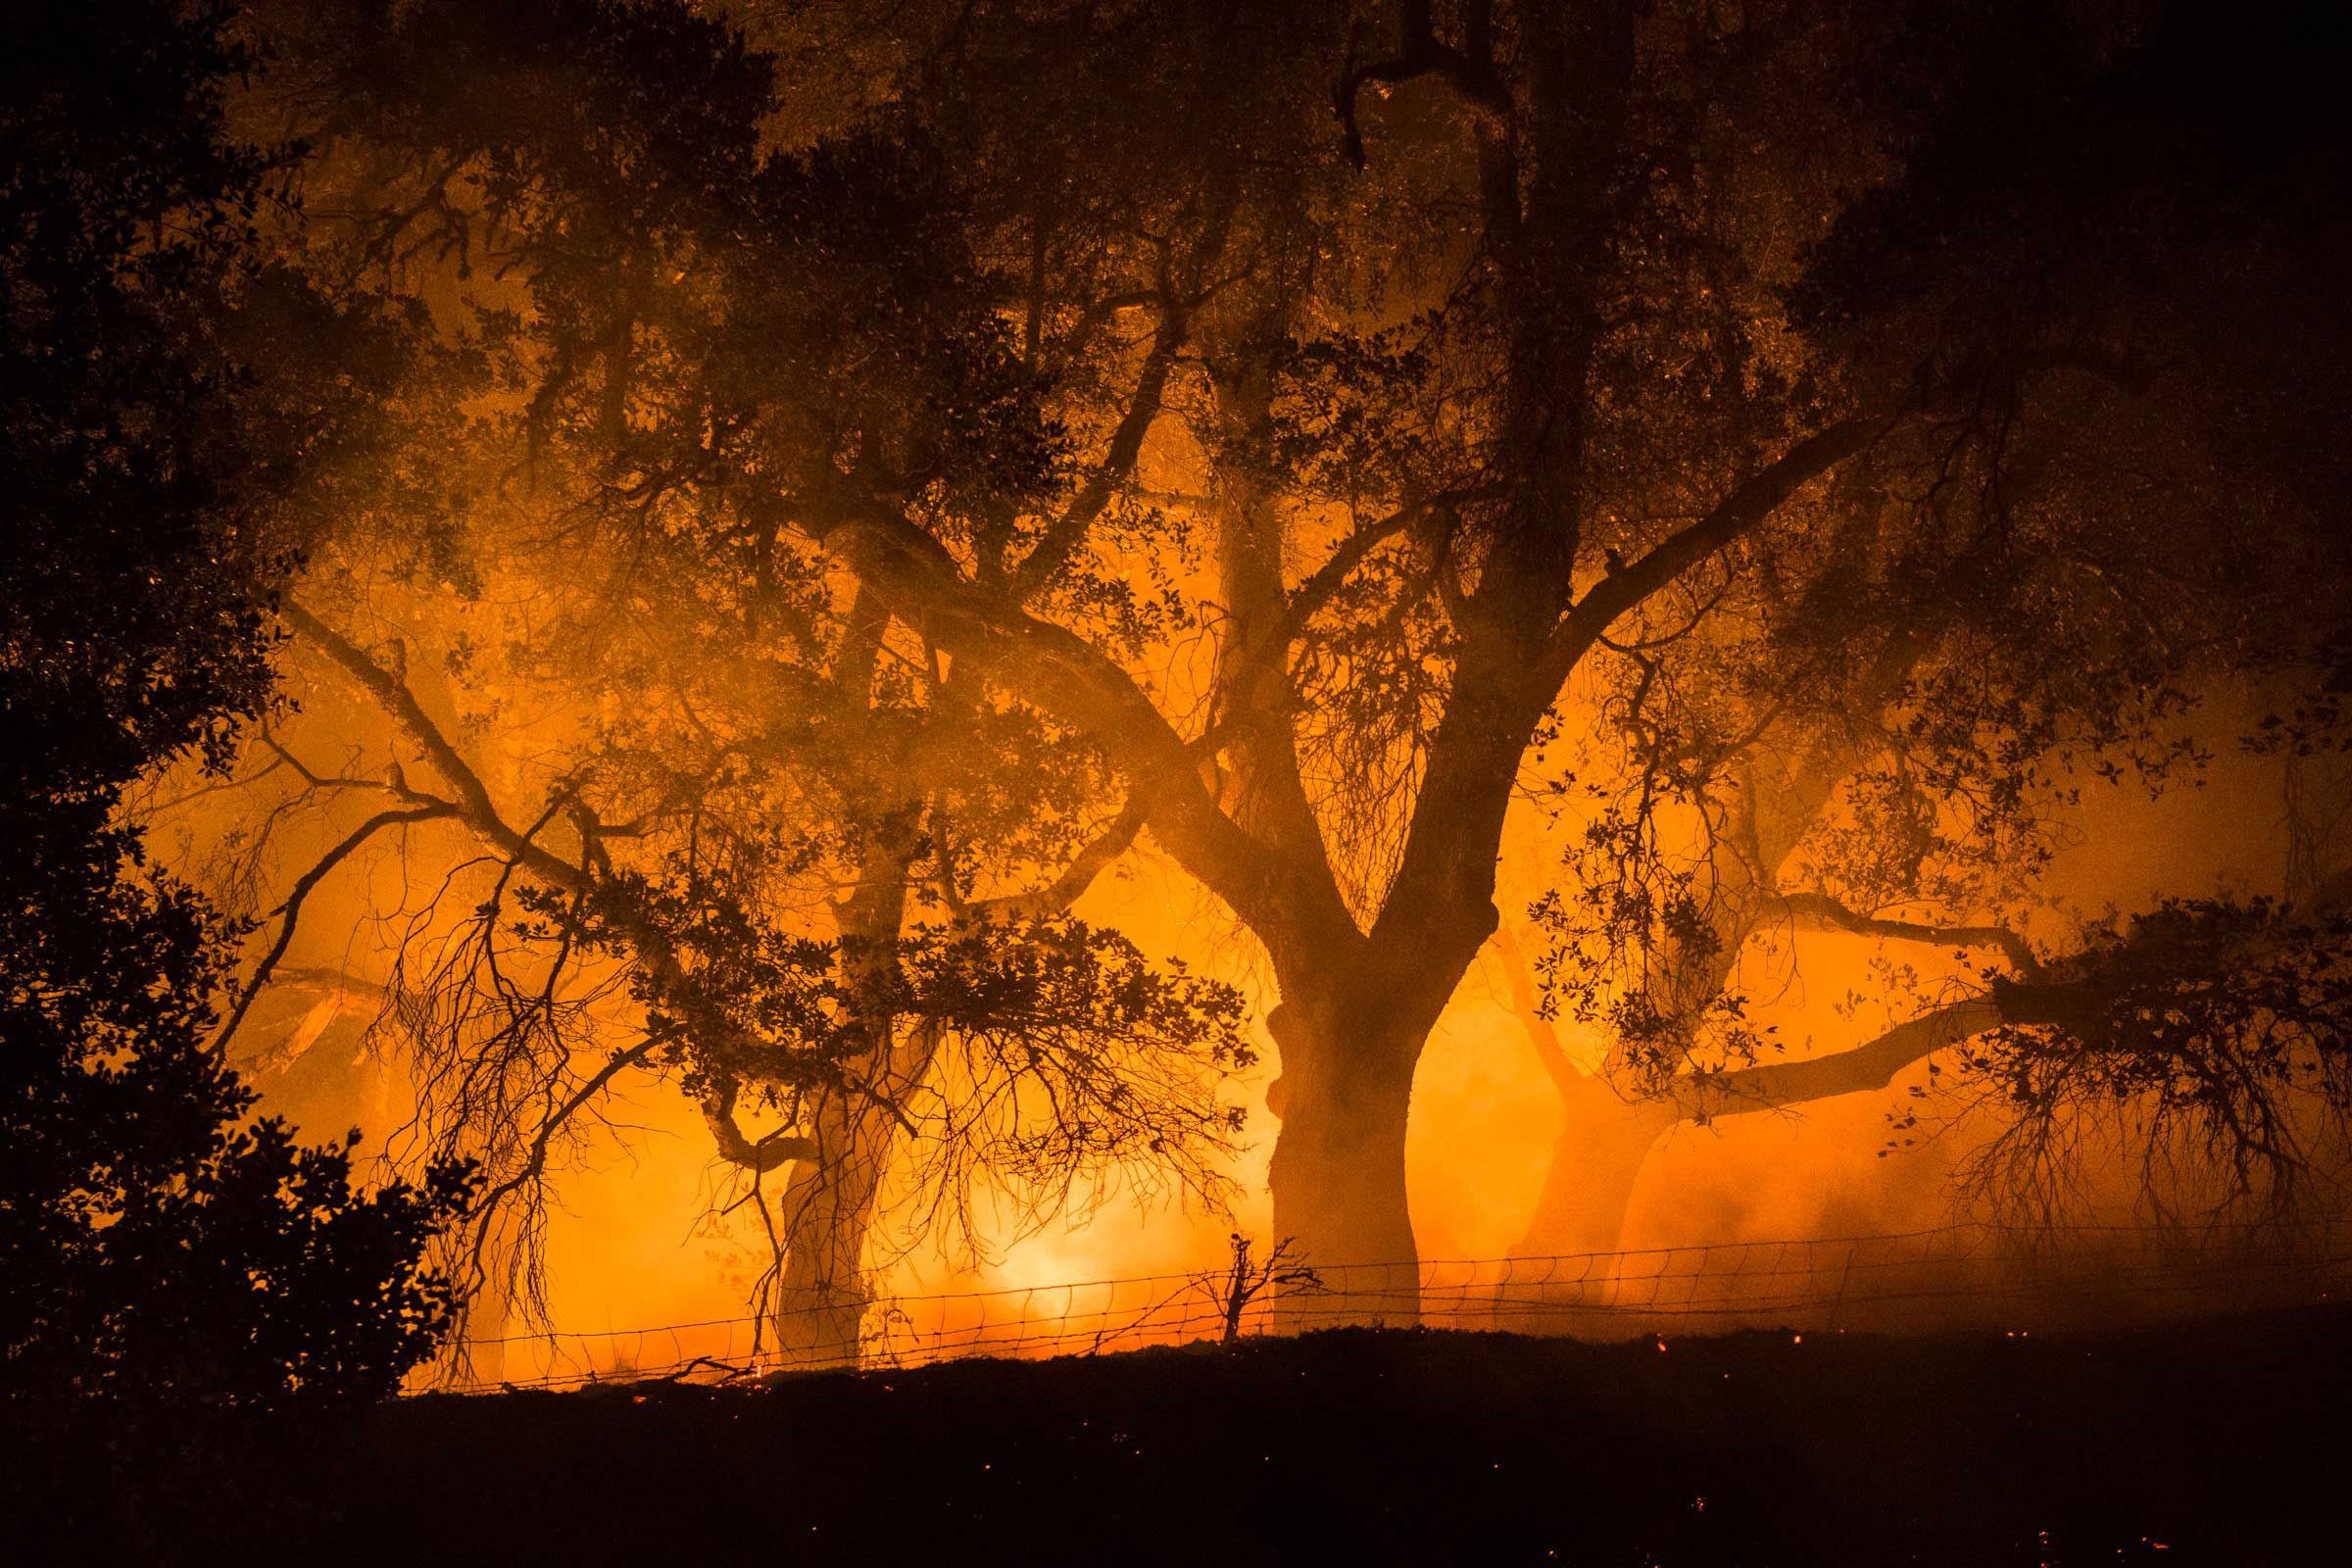

In [338]:
fire = list(data_dir.glob('fire_images/*'))
PIL.Image.open(str(fire[40]))

In [339]:
batch_size = 32
img_height = 180
img_width = 180

In [340]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 999 files belonging to 2 classes.
Using 800 files for training.


In [341]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 999 files belonging to 2 classes.
Using 199 files for validation.


In [342]:
class_names = train_ds.class_names
print(class_names)

['fire_images', 'non_fire_images']


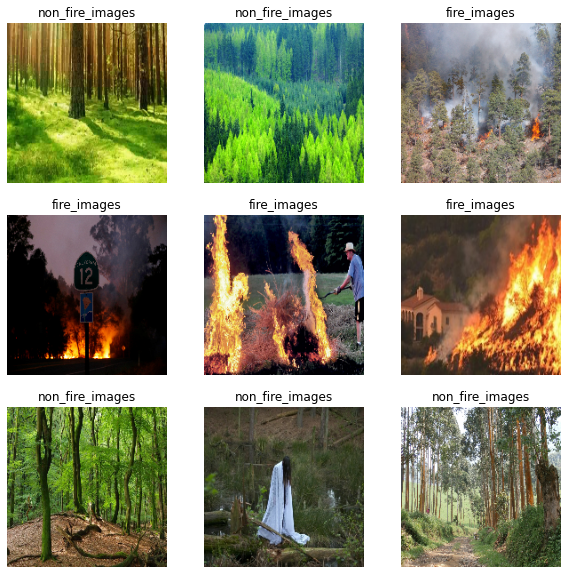

In [343]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [344]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [345]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [346]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [347]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [348]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu', padding='same', input_shape=(180, 180, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dropout(0.4),  
  tf.keras.layers.Dense(1, activation='softmax')
])

In [349]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_53 (Conv2D)          (None, 45, 45, 64)        36928     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 22, 22, 64)     

In [350]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [351]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
25/25 [==============================] - 5s 123ms/step - loss: 25.7620 - accuracy: 0.2438 - val_loss: 0.3843 - val_accuracy: 0.2462
Epoch 2/5
25/25 [==============================] - 0s 20ms/step - loss: 0.3679 - accuracy: 0.2438 - val_loss: 0.2797 - val_accuracy: 0.2462
Epoch 3/5
25/25 [==============================] - 0s 19ms/step - loss: 0.2769 - accuracy: 0.2438 - val_loss: 0.2126 - val_accuracy: 0.2462
Epoch 4/5
25/25 [==============================] - 0s 19ms/step - loss: 0.2649 - accuracy: 0.2438 - val_loss: 0.1927 - val_accuracy: 0.2462
Epoch 5/5
25/25 [==============================] - 0s 19ms/step - loss: 0.2390 - accuracy: 0.2438 - val_loss: 0.2766 - val_accuracy: 0.2462


In [352]:
model.save_weights('model-fire2-weights.h5')

In [353]:
model.save('model-fire2-whole.h5')

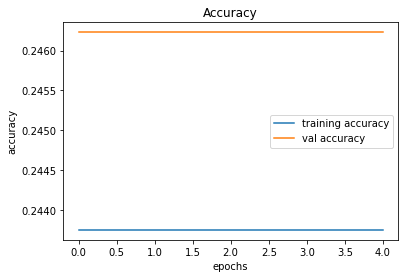

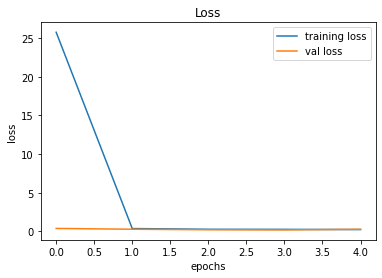

In [354]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Accuracy")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()